# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [43]:
# Install the required libraries
!pip install prophet

In [44]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [45]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date', 
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/z7/8qp96g0d3r3b0tsph5j2f5m80000gn/T/ipykernel_24489/1096498906.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_trends = pd.read_csv(


/var/folders/z7/8qp96g0d3r3b0tsph5j2f5m80000gn/T/ipykernel_24489/1096498906.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [46]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: title={'center': 'Google Hourly Search Trends for May 2020'}, xlabel='Date'>

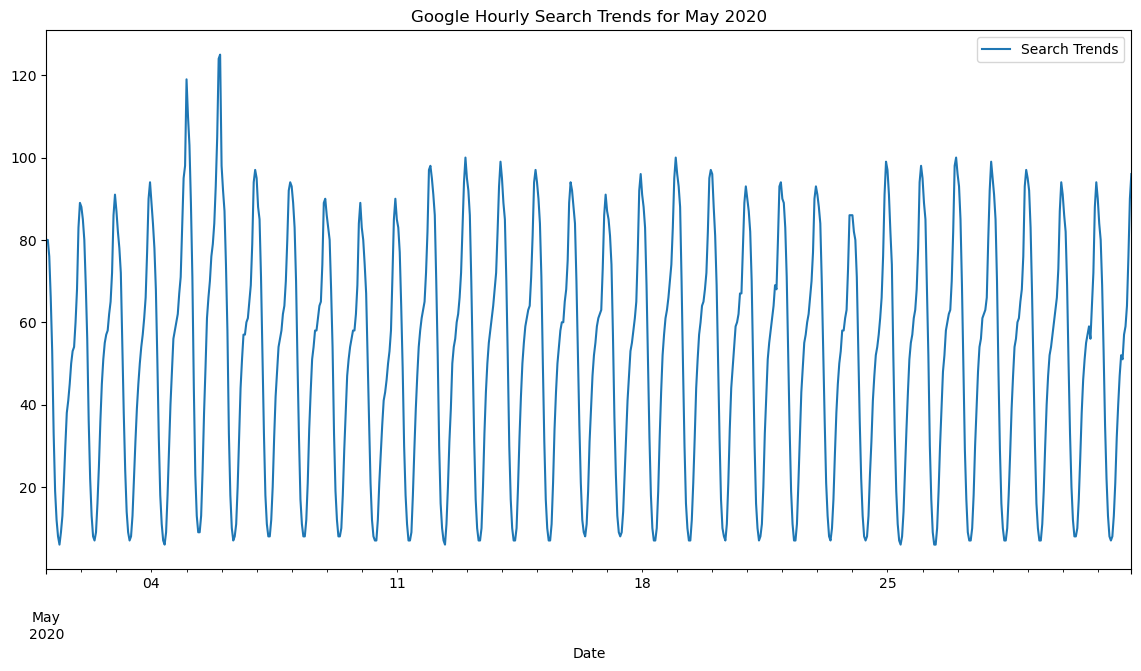

In [47]:
# Slice the DataFrame to just the month of May 2020
df_mercado_trends_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']
# Plot to visualize the data for May 2020
df_mercado_trends_may_2020.plot(figsize=(14, 7), title="Google Hourly Search Trends for May 2020")


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [48]:
#calculate the sum of the search trends for the month of May 2020
traffic_may_2020 = df_mercado_trends_may_2020['Search Trends'].sum()
# View the traffic_may_2020 value
# print("Search Trends",traffic_may_2020)
# print("dtype:", traffic_may_2020.dtype)
traffic_may_2020

38181

In [49]:
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


In [50]:
df_mercado_trends['Search Trends'].describe()

count    37106.000000
mean        48.128739
std         27.171429
min          0.000000
25%         24.000000
50%         51.000000
75%         68.000000
max        125.000000
Name: Search Trends, dtype: float64

In [51]:
# Calculate the sum of the total search traffic for May 2020
slice_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# View the traffic_may_2020 value
slice_may_2020

,Search Trends
Date,
2020-05-01 00:00:00,80
2020-05-01 01:00:00,80
2020-05-01 02:00:00,76
2020-05-01 03:00:00,66
2020-05-01 04:00:00,53
...,...
2020-05-31 19:00:00,59
2020-05-31 20:00:00,64
2020-05-31 21:00:00,76


In [52]:
# Calculate the sum of the total search traffic for May 2020
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()
# Calcluate the monthly median search traffic across all months 
monthly_median_search_traffic = df_mercado_trends['Search Trends'].resample('M').median()

# View the monthly median search traffic values
print("median_monthly_traffic", median_monthly_traffic)

median_monthly_traffic Search Trends    35172.5
dtype: float64


In [53]:
# To compare the seach traffic for the month of May 2020 to the overall monthly median value,
# Divide the may traffic total by the median monthly traffic
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question: 

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** 
By looking at the mean for the entire year vs May 2020 we see a value that is increased by .08 % in May when the financial results came out.


## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [54]:
# Group the hourly search data to plot the average traffic by the day of week 
hourly_search_ = df_mercado_trends['Search Trends'].resample('H').median()
hourly_search_

Date
2016-06-01 00:00:00    97.0
2016-06-01 01:00:00    92.0
2016-06-01 02:00:00    76.0
2016-06-01 03:00:00    60.0
2016-06-01 04:00:00    38.0
                       ... 
2020-09-07 20:00:00    71.0
2020-09-07 21:00:00    83.0
2020-09-07 22:00:00    96.0
2020-09-07 23:00:00    97.0
2020-09-08 00:00:00    96.0
Freq: H, Name: Search Trends, Length: 37441, dtype: float64

In [55]:
# Group the hourly search data to plot the average traffic by hour of the day
df_mercado_trends_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()
df_mercado_trends.head()

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


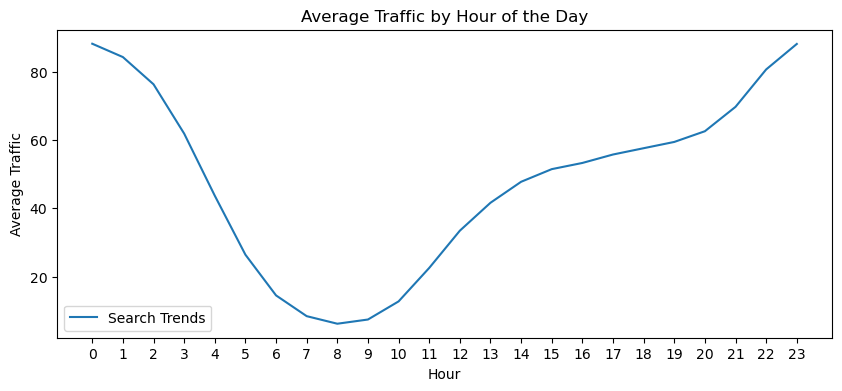

In [56]:
# Group the hourly search data to plot the average traffic by hour of the day
df_mercado_trends_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean().plot(figsize=(10, 4))
plt.xlabel('Hour')  # Change the x-axis label
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Hour of the Day')

# Customize the ticks on the x-axis to show more hour labels
plt.xticks(range(0, 24))  # Set ticks for every hour from 0 to 23

plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

In [57]:
# Group the hourly search data to plot the average traffic by the day of week 
hourly_search_= df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean()
hourly_search_

,Search Trends
Date,
0,49.522813
1,50.571672
2,50.219604
3,49.699661
4,48.621041
5,45.125377
6,43.151207


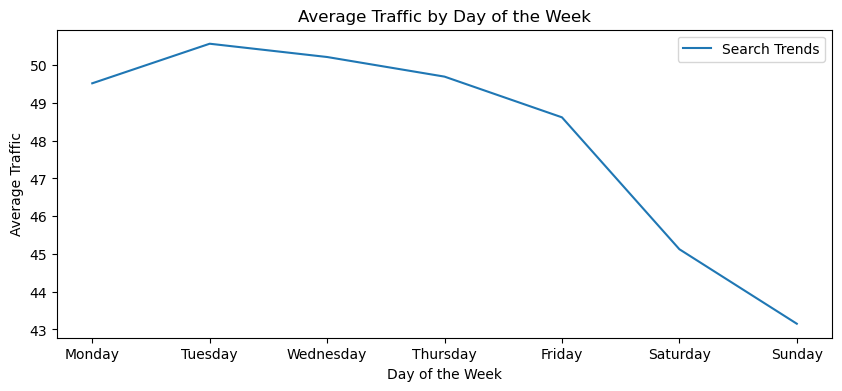

In [58]:
# Group the hourly search data to plot the average traffic by the day of the week
df_mercado_trends_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean().plot(figsize=(10, 4))

# Customize the x-axis ticks to show day names instead of numerical representations
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.xlabel('Day of the Week')  # Change the x-axis label
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Day of the Week')

plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

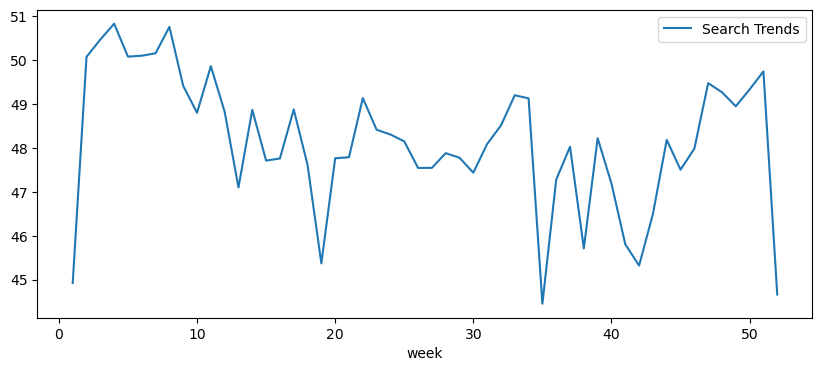

In [59]:
# Group the hourly search data to plot the average traffic by the week of the year 
df_mercado_trends_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean().plot(figsize=(10,4))


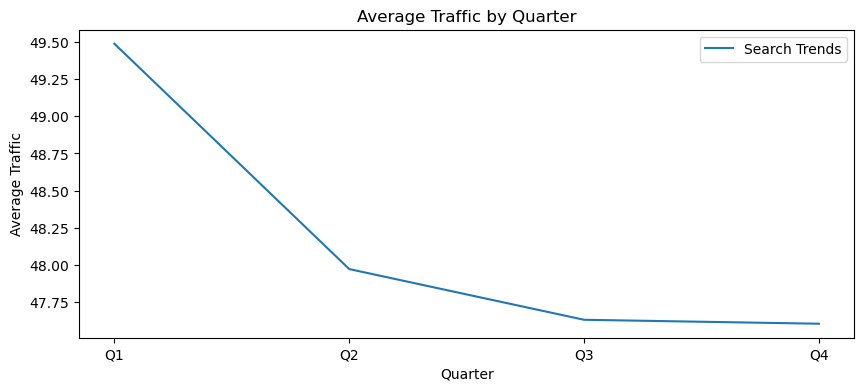

In [60]:
# Define a function to map quarter numbers to labels
def quarter_to_label(quarter):
    if quarter == 1:
        return 'Q1'
    elif quarter == 2:
        return 'Q2'
    elif quarter == 3:
        return 'Q3'
    elif quarter == 4:
        return 'Q4'
    else:
        return str(quarter)

# Group the hourly search data to plot the average traffic by quarters
df_mercado_trends_quarters = df_mercado_trends.groupby(df_mercado_trends.index.quarter).mean().plot(figsize=(10,4))

# Set custom tick labels for the x-axis using the quarter_to_label function
plt.xticks(ticks=range(1, 5), labels=[quarter_to_label(q) for q in range(1, 5)])

# Add labels and title
plt.xlabel('Quarter')
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Quarter')

plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data? 

**Answer:** 
- Hourly Search - starts off very high after midnight then starts a downward trend until around 8 am where when the mornign starts and the day progresses the activity increases. It seems many people are searching Mercado libre and it is at its peak around midnight. 
- Day of the week - The search activity is high at the beginning of the week and then starts downward as the weekend approaches. 
- Week of the year:
-- During the year by quarter the search activity is high at the beginning of the year in Q1 and then starts a downward trend to Q2 and Q3 and reaches its lowest point in Q4

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [61]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

/var/folders/z7/8qp96g0d3r3b0tsph5j2f5m80000gn/T/ipykernel_24489/880024568.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_stock = pd.read_csv(


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


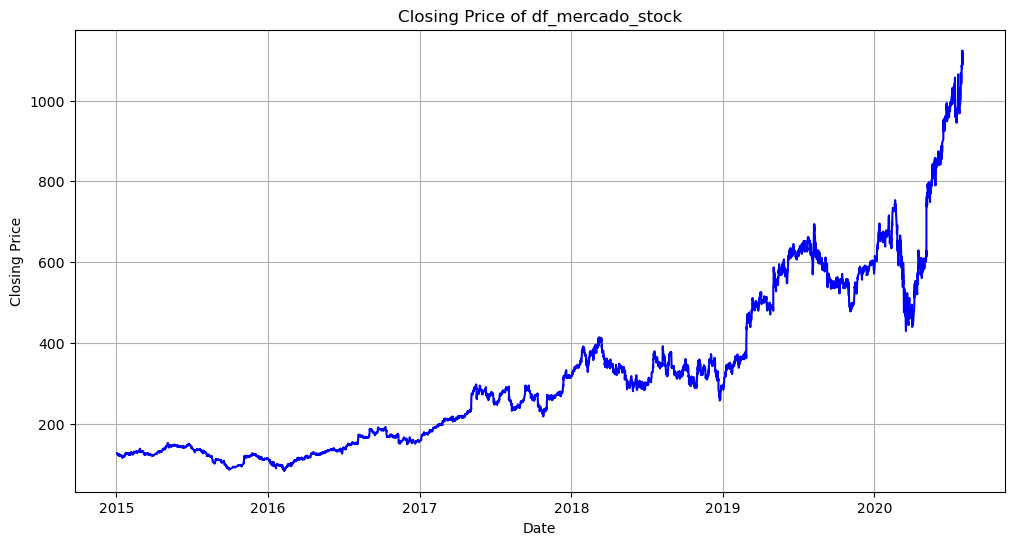

In [62]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], color='blue')
plt.title('Closing Price of df_mercado_stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [63]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
# Concatenate the DataFrames
df_merged_mercado = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

# Drop rows with only one column of data
df_merged_mercado = df_merged_mercado.dropna(thresh=2)

# Display the resulting DataFrame
print(df_merged_mercado)

# View the first and last five rows of the DataFrame
display(df_merged_mercado.head())
display(df_merged_mercado.tail())

                        close  Search Trends
2016-06-01 09:00:00   135.160            6.0
2016-06-01 10:00:00   136.630           12.0
2016-06-01 11:00:00   136.560           22.0
2016-06-01 12:00:00   136.420           33.0
2016-06-01 13:00:00   136.100           40.0
...                       ...            ...
2020-07-31 11:00:00  1105.780           20.0
2020-07-31 12:00:00  1087.925           32.0
2020-07-31 13:00:00  1095.800           41.0
2020-07-31 14:00:00  1110.650           47.0
2020-07-31 15:00:00  1122.510           53.0

[7067 rows x 2 columns]


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [64]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06) 
df_firsthalf = df_merged_mercado.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(df_firsthalf.head())
display(df_firsthalf.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: >, <Axes: >], dtype=object)

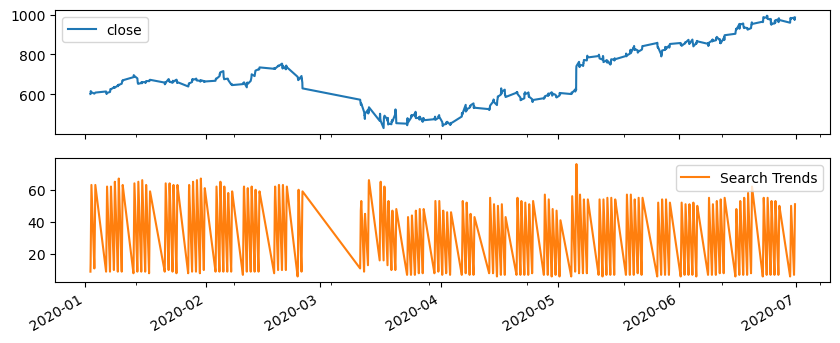

In [65]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
df_firsthalf.plot(subplots=True, figsize=(10,4))

<Axes: xlabel='date'>

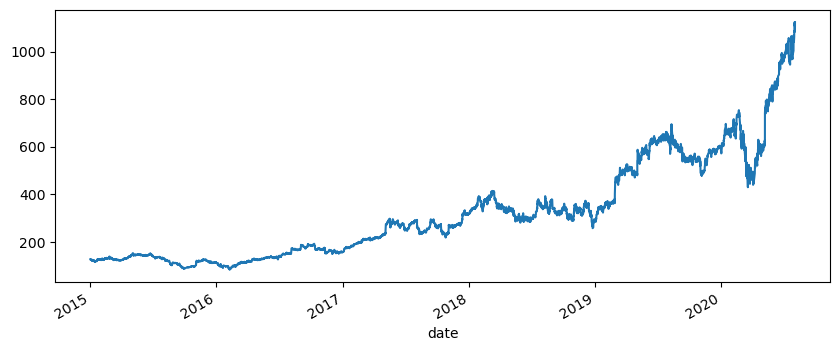

In [66]:
# Visualize the closing price of the df_mercado_stock DataFrame
#df_mercado_stock.loc["2015-01-02 09:00:00":"2020-07-31 15:00:00"]["close"].plot()
df_mercado_stock["close"].plot(figsize=(10,4))


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** In truth, our evidence of a common trend between search activity and stock price is pretty limited. It does appear generally however that the low point for Mercado Libre's stock price, late March to early April, did coincide with lower search activity for the firm. Search activity does pick up along with its stock price, although the stock price from mid-April onward definitively outpaces search interest.

There's one important thing to note: if you zoom in both graphs to the spike around May 5th, 2020, you'll find the date of the company's earnings release to the public. It looks like search traffic for the firm spiked about two hours before the firm's stock price spiked. This could indicate a predictable pattern (can Google Searches predict the stock price?), but an alternative explanation might just be that people tend to search for more information about the firm right before an earnings announcement gets released. We'd need to do a little more time-series research to see which explanation best fits the data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [67]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_merged_mercado ["Lagged Search Trends"] = df_merged_mercado["Search Trends"].shift(1)
df_merged_mercado .head()


,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [68]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
# dataframe[‘column’]..pct_change().rolling(window=4).std()
df_merged_mercado ["Stock Volatility"] = df_merged_mercado ["close"].pct_change().rolling(window=4).std()



In [69]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(df_merged_mercado.head())
display(df_merged_mercado.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134


,close,Search Trends,Lagged Search Trends,Stock Volatility
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566


<Axes: >

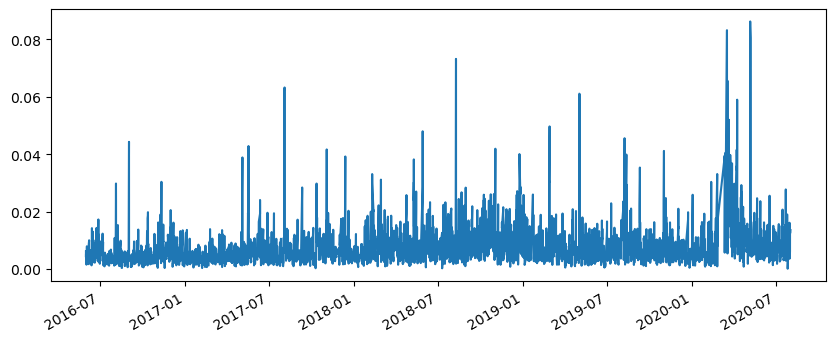

In [70]:
# Visualize the stock volatility
df_merged_mercado ["Stock Volatility"].plot(figsize=(10,4))


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [71]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
df_merged_mercado["Hourly Stock Return"] = df_merged_mercado ["close"].pct_change()


In [72]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(df_merged_mercado.head())
display(df_merged_mercado.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [73]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
df_merged_mercado[["Stock Volatility", "Lagged Search Trends", "Hourly Stock Return"]].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


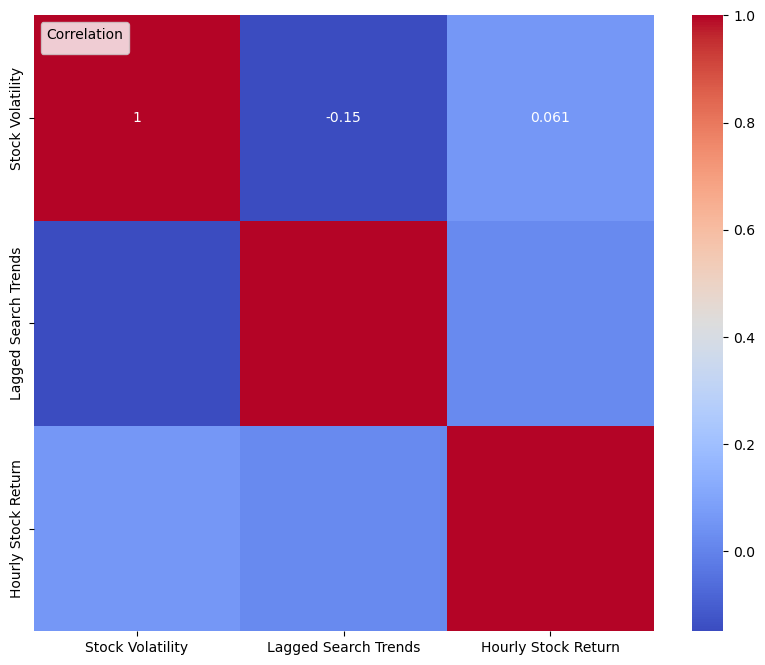

In [74]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_matrix = df_merged_mercado[["Stock Volatility", "Lagged Search Trends", "Hourly Stock Return"]].corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Plot the heatmap with seaborn
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add a custom legend
legend_labels = ['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']
plt.legend(title='Correlation', labels=legend_labels, loc='upper left')

# Show the plot
plt.show()

##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?
**Red** indicates positive correlations between variables so when one variable increases the other increases as well
**Blue** indicates negative correlations between variables so when one variable increases the other goes the other variable descreases 
**Answer:** if you look at the heatmap visualization its easier to understand the correlation here is what it shows:
- Laggard search to Stock Volatility - there seems to be a negative correlation which means when the stock is more volatile it negatively impacts laggard search trends. 
- Laggard search to Stock Price Returns It looks like has stock returns goes up the laggard search descreases 


## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [75]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends = df_mercado_trends.rename(columns={"Date": "ds", "Search Trends": "y"})

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = df_mercado_trends.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [76]:
# Call the Prophet function, store as an object
m = Prophet()
m

In [77]:
# Fit the time-series model.
m.fit(df_mercado_trends)

15:25:20 - cmdstanpy - INFO - Chain [1] start processing


15:25:32 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future = m.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
display(future.tail())

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [79]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forcast_mercado_trends = m.predict(future)

# Display the first five rows of the forecast_mercado_trends DataFrame
forcast_mercado_trends.head()
forcast_mercado_trends.tail()
forcast_mercado_trends.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


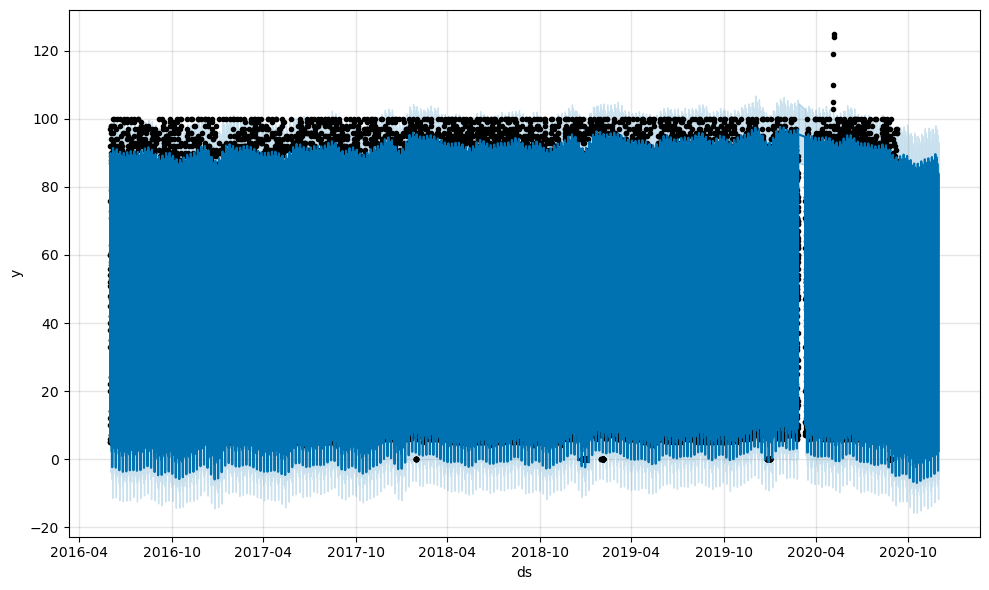

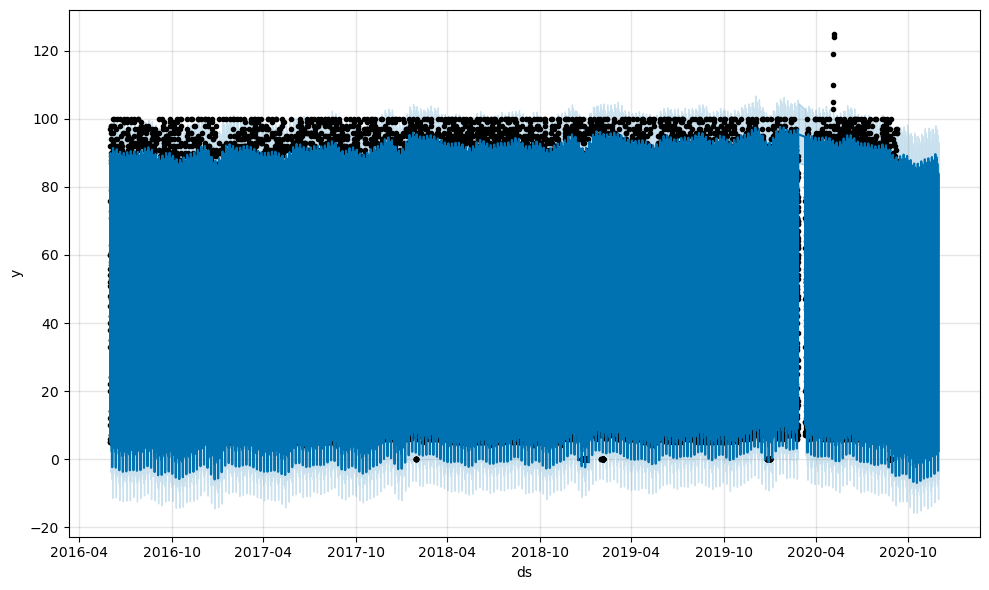

In [80]:
# Plot the Prophet predictions for the Mercado trends data
m.plot(forcast_mercado_trends)

In [81]:
# Display the near-term forecast (last few rows) including yhat, yhat_lower, and yhat_upper
print(forcast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail())

            yhat  yhat_lower  yhat_upper
39101  39.283272   30.797144   47.874056
39102  23.812065   15.666821   33.136841
39103  11.846318    3.061752   20.403319
39104   4.574080   -4.086752   12.745872
39105   2.379109   -5.833781   11.061758


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast suggests a downward trend in search traffic for Mercado Libre during the specified time period, also there is a varying degrees of uncertainty in the predictions.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity? Around midnight seems to be the highest level of activity. 

* Which day of the week gets the most search traffic? Tuesday 

* What's the lowest point for search traffic in the calendar year? Beginning of November 


In [82]:
# Display the near-term forecast (last few rows) including yhat, yhat_lower, and yhat_upper
print(forcast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail())


            yhat  yhat_lower  yhat_upper
39101  39.283272   30.797144   47.874056
39102  23.812065   15.666821   33.136841
39103  11.846318    3.061752   20.403319
39104   4.574080   -4.086752   12.745872
39105   2.379109   -5.833781   11.061758


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Axes: >

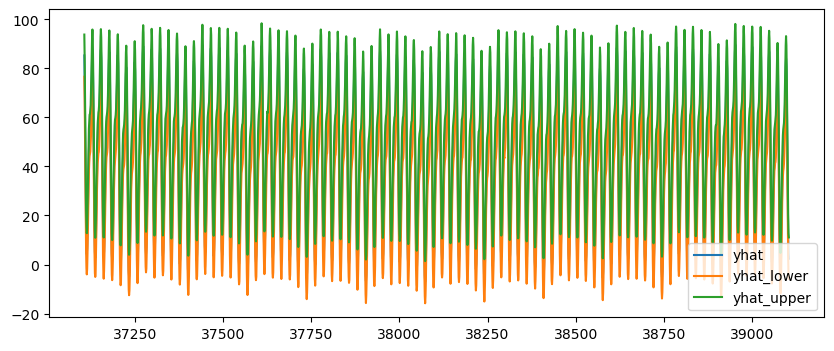

In [83]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours 
forcast_mercado_trends [['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:,:].plot(figsize=(10,4))

/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

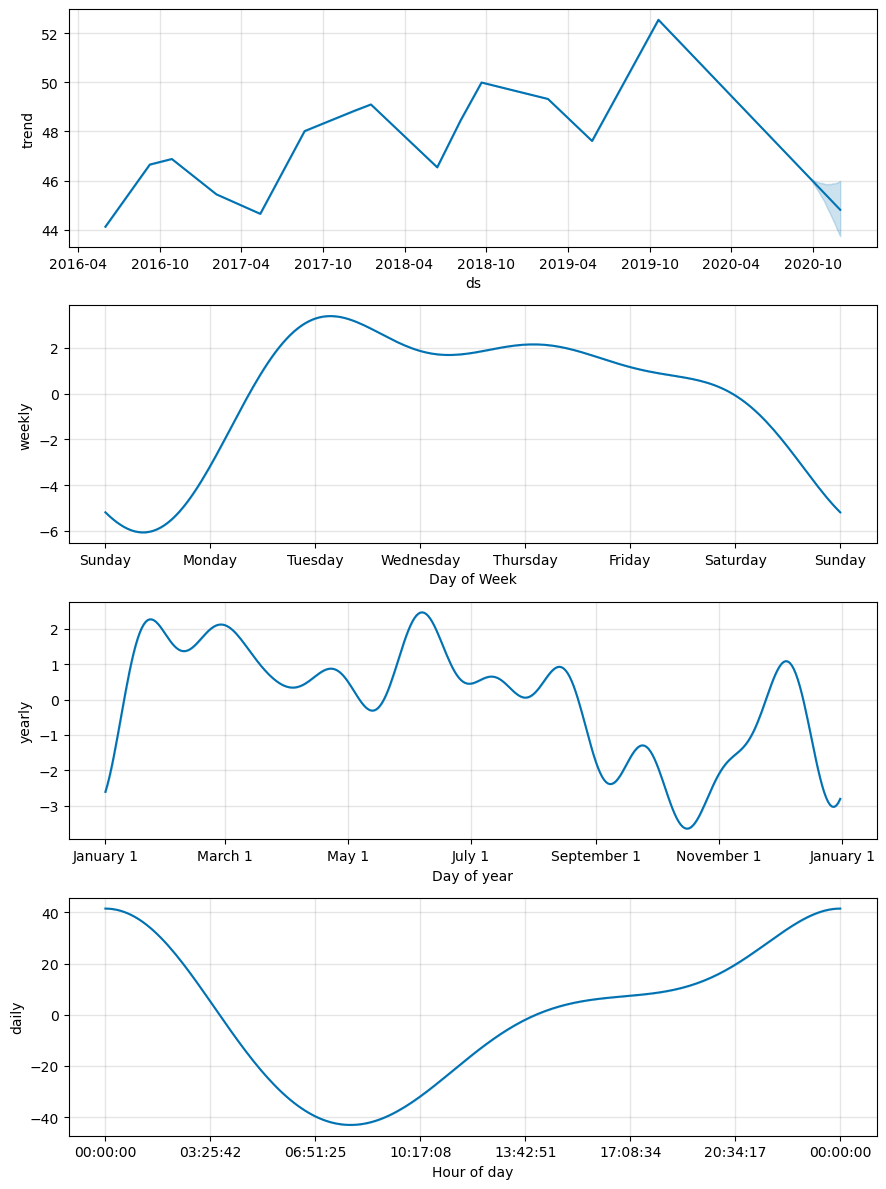

In [84]:
# Reset the index in the forecast_mercado_trends DataFrame
forcast_mercado_trends= forcast_mercado_trends.reset_index()
forcast_mercado_trends.head()

# Use the plot_components function to visualize the forecast results 
# for the forecast_canada DataFrame 
fig_forecast_mercado_trends = m.plot_components(forcast_mercado_trends)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** It seems that around midnight is there is the highest level of activity

**Question:** Which day of week gets the most search traffic? 
   
**Answer:** Tuesday has the highest leavel of search traffic 

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**  The beginning of Novembers seems to be the lowest point of search traffic 
